# Data analysis for the paper "Automated Generation of Consistent Models with Structural and Attribute Constraints"

First, let's load some packages.

In [57]:
require(tidyverse)
dir.create('plots')

The functions below parse the logs generated by VIATRA Generator. We use a separate function for logs with 10 generated models, and another one for a single generated model per run.

In [43]:
ProcessDetailedStatistics <- function(str) {
    str <- sub('TransformationExecutionTime', 'TransformationExecutionTime:', str)
    str <- sub('Backtrackingtime', 'BacktrackingTime', str)
    str <- gsub('\\(|\\)', '', str)
    str <- lapply(strsplit(str, '\\||:'), function (v) {
        dim(v) <- c(2, 12)
        values <- as.double(v[2,])
        names(values) <- v[1,]
        as.data.frame(t(values))
    })
    str
}
Load10Log <- function(filename, size) {
    read_csv(filename, col_types = cols(
      .default = col_double(),
      Result = col_character(),
      Solution1DetailedStatistics = col_character(),
      Solution2DetailedStatistics = col_character(),
      Solution3DetailedStatistics = col_character(),
      Solution4DetailedStatistics = col_character(),
      Solution5DetailedStatistics = col_character(),
      Solution6DetailedStatistics = col_character(),
      Solution7DetailedStatistics = col_character(),
      Solution8DetailedStatistics = col_character(),
      Solution9DetailedStatistics = col_character(),
      Solution10DetailedStatistics = col_character()
    )) %>% transmute(
        n = size,
        Run = Run,
        preprocessingTime = get('Domain to logic transformation time') + get('Logic to solver transformation time') + ExplorationInitializationTime,
        Solution0FoundAt = Solution0FoundAt,
        additionalTime = Solution9FoundAt - Solution0FoundAt,
        Solution1DetailedStatistics = ProcessDetailedStatistics(Solution1DetailedStatistics)
    ) %>% unnest() %>% mutate(
        # (Logical) constraint evluation should count as refinement.
        ForwardTime = ForwardTime + GlobalConstraintEvaluationTime + FitnessCalculationTime,
        preprocessingTime = preprocessingTime,
        BacktrackingTime = Solution0FoundAt - (StateCoderTime + ForwardTime + NumericalSolverSumTime)
    ) %>% select(n, Run, preprocessingTime, StateCoderTime, ForwardTime, BacktrackingTime, NumericalSolverSumTime, additionalTime)
}
Load1Log <- function(filename, size) {
    read_csv(filename, col_types = cols(
      .default = col_double(),
      Result = col_character(),
      Solution1DetailedStatistics = col_character()
    )) %>% filter(Result == "ModelResultImpl") %>% transmute(
        n = size,
        Run = Run,
        preprocessingTime = get('Domain to logic transformation time') + get('Logic to solver transformation time') + ExplorationInitializationTime,
        Solution0FoundAt = Solution0FoundAt,
        Solution1DetailedStatistics = ProcessDetailedStatistics(Solution1DetailedStatistics)
    ) %>% unnest(cols = c(Solution1DetailedStatistics)) %>% mutate(
        ForwardTime = ForwardTime + GlobalConstraintEvaluationTime + FitnessCalculationTime,
        BacktrackingTime = Solution0FoundAt - (StateCoderTime + ForwardTime + NumericalSolverSumTime)
    ) %>% select(n, Run, preprocessingTime, StateCoderTime, ForwardTime, BacktrackingTime, NumericalSolverSumTime)
}

Next, we set up data analyses for the first three research questions.

  * **RQ1** only needs the total runtimes of the generator, so we sum the runtimes of the individual phases and take the media.
  * **RQ2** takes the median of all phases individually.
  * **RQ3** only needs the total runtimes, so we use the same function as for RQ1.

In [44]:
ProcessRQ1 <- function(df) {
    df %>% group_by(n) %>% summarize(
        .groups = 'drop',
        time = median(preprocessingTime + StateCoderTime + ForwardTime + BacktrackingTime + NumericalSolverSumTime) / 1000.0
    )
}
ProcessRQ2 <- function(df) {
    df %>% group_by(n) %>% summarize(
        .groups = 'drop',
        preprocessingTime = median(preprocessingTime) / 1000.0,
        StateCoderTime = median(StateCoderTime) / 1000.0,
        ForwardTime = median(ForwardTime) / 1000.0,
        BacktrackingTime = median(BacktrackingTime) / 1000.0,
        NumericalSolverSumTime = median(NumericalSolverSumTime) / 1000.0,
        additionalTime = median(additionalTime) / 1000.0
    )
}
ProcessRQ3 <- ProcessRQ1

## RQ1

We parse all the logs for RQ1, then output the total runtimes as a table for making sure there were no parse errors.

In [45]:
RQ1 <- rbind(
    rbind(
        Load1Log('measurements/stats/FamilyTreeSMTEnd/size05to05r10n1rt300stats.csv', 5),
        Load1Log('measurements/stats/FamilyTreeSMTEnd/size06to06r10n1rt300stats.csv', 6)
    ) %>% ProcessRQ1 %>% mutate(name="postSMT"),
    rbind(
        Load1Log('measurements/stats/FamilyTree/size05to05r10n1rt300stats.csv', 5),
        Load1Log('measurements/stats/FamilyTree/size06to06r10n1rt300stats.csv', 6),
        Load1Log('measurements/stats/FamilyTree/size07to07r10n1rt300stats.csv', 7),
        Load1Log('measurements/stats/FamilyTree/size08to08r10n1rt300stats.csv', 8),
        Load1Log('measurements/stats/FamilyTree/size09to09r10n1rt300stats.csv', 9),
        Load1Log('measurements/stats/FamilyTree/size010to010r10n1rt300stats.csv', 10),
        Load1Log('measurements/stats/FamilyTree/size020to020r10n1rt300stats.csv', 20),
        Load1Log('measurements/stats/FamilyTree/size040to040r10n1rt300stats.csv', 40),
        Load1Log('measurements/stats/FamilyTree/size060to060r10n1rt300stats.csv', 60),
        Load1Log('measurements/stats/FamilyTree/size080to080r10n1rt300stats.csv', 80),
        Load1Log('measurements/stats/FamilyTree/size100to100r10n1rt300stats.csv', 100)
    ) %>% ProcessRQ1 %>% mutate(name="contSMT"),
    rbind(
        Load1Log('measurements/stats/FamilyTreeSMTQual/size05to05r10n1rt300stats.csv', 5),
        Load1Log('measurements/stats/FamilyTreeSMTQual/size06to06r10n1rt300stats.csv', 6),
        Load1Log('measurements/stats/FamilyTreeSMTQual/size07to07r10n1rt300stats.csv', 7),
        Load1Log('measurements/stats/FamilyTreeSMTQual/size08to08r10n1rt300stats.csv', 8),
        Load1Log('measurements/stats/FamilyTreeSMTQual/size09to09r10n1rt300stats.csv', 9),
        Load1Log('measurements/stats/FamilyTreeSMTQual/size010to010r10n1rt300stats.csv', 10),
        Load1Log('measurements/stats/FamilyTreeSMTQual/size020to020r10n1rt300stats.csv', 20),
        Load1Log('measurements/stats/FamilyTreeSMTQual/size040to040r10n1rt300stats.csv', 40),
        Load1Log('measurements/stats/FamilyTreeSMTQual/size060to060r10n1rt300stats.csv', 60),
        Load1Log('measurements/stats/FamilyTreeSMTQual/size080to080r10n1rt300stats.csv', 80),
        Load1Log('measurements/stats/FamilyTreeSMTQual/size100to100r10n1rt300stats.csv', 100)
    ) %>% ProcessRQ1 %>% mutate(name="qualSMT")
)
RQ1$name <- factor(RQ1$name, levels=c("postSMT", "contSMT", "qualSMT"))
RQ1

n,time,name
<dbl>,<dbl>,<fct>
5,27.4965,postSMT
6,259.5700,postSMT
5,1.4045,contSMT
6,1.5770,contSMT
7,1.7190,contSMT
8,2.0000,contSMT
9,2.1440,contSMT
10,2.4360,contSMT
20,6.0530,contSMT


Now we are ready to plot the runtimes.

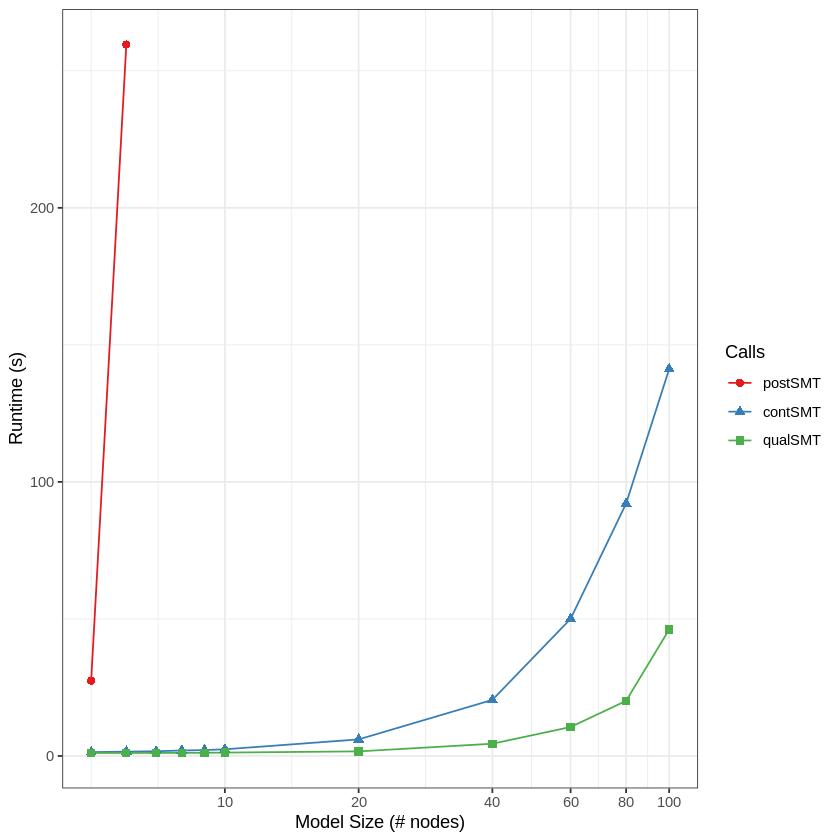

In [46]:
RQ1Plot <- RQ1 %>% ggplot(aes(x=n, y=time, color=name, shape=name)) +
    scale_color_brewer(name="Calls", palette="Set1") +
    scale_shape_discrete(name="Calls") +
    scale_x_log10(name="Model Size (# nodes)", breaks=c(10, 20, 40, 60, 80, 100)) +
    scale_y_continuous(name="Runtime (s)") +
    geom_line() +
    geom_point(size=2) +
    theme_bw()
ggsave(plot=RQ1Plot, filename='plots/plot_RQ1.pdf', width=5, height=1.5*5/4)
RQ1Plot

## RQ2

In RQ2, we will have to create 3 different plots, so we factor them out into a function.

In [47]:
RQ2Plot <- function(df, name) {
    df <- df %>% gather(name, value, -n) %>% filter(name != "preprocessingTime")
    df$name <- factor(df$name, levels=rev(c('ForwardTime', 'BacktrackingTime', 'StateCoderTime', 'NumericalSolverSumTime', 'additionalTime')))
    plot <- df %>% ggplot(aes(x=n, y=value, fill=name)) +
        geom_bar(stat='identity') +
        scale_fill_brewer(palette='Set2',
                          labels=rev(c('Refinement', 'Backtracking', 'State Coding', 'SMT Solver Calls', 'Additional Model Generation')),
                          guide=FALSE) +
        scale_x_continuous(breaks=c(20, 40, 60, 80, 100), name="Model Size (# nodes)") +
        scale_y_continuous(name="Runtime (s)") +
        theme_bw()
    ggsave(plot=plot, filename=paste0('plots/plot_RQ2_', name, '.pdf'), width=3.5, height=2.5)
    plot
}

In order to create the plots for RQ1,
  1. we first parse the logs for each of the 3 case studies;
  2. then we display the aggregated results as a table for error checking;
  3. calculate the median preprocessing time (in secods), which stays constant regardless the model size;
  4. and create a bar chart for the rest of the generation phases.

### Fam domain

Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(Solution1DetailedStatistics)`”
Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(Solution1DetailedStatistics)`”
Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(Solution1DetailedStatistics)`”
Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(Solution1DetailedStatistics)`”
Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(Solution1DetailedStatistics)`”


n,preprocessingTime,StateCoderTime,ForwardTime,BacktrackingTime,NumericalSolverSumTime,additionalTime
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20,0.8940,0.1240,0.2330,0.1470,5.2680,4.4290
40,0.8915,0.9295,0.9555,0.6070,19.1820,8.1975
60,0.8745,2.3945,1.7300,1.0685,37.7305,14.2310
80,0.8810,5.7395,3.8205,2.4985,72.2415,17.4985
100,0.8770,11.5395,6.3625,4.5380,124.5385,31.9565


[1] 0.8785

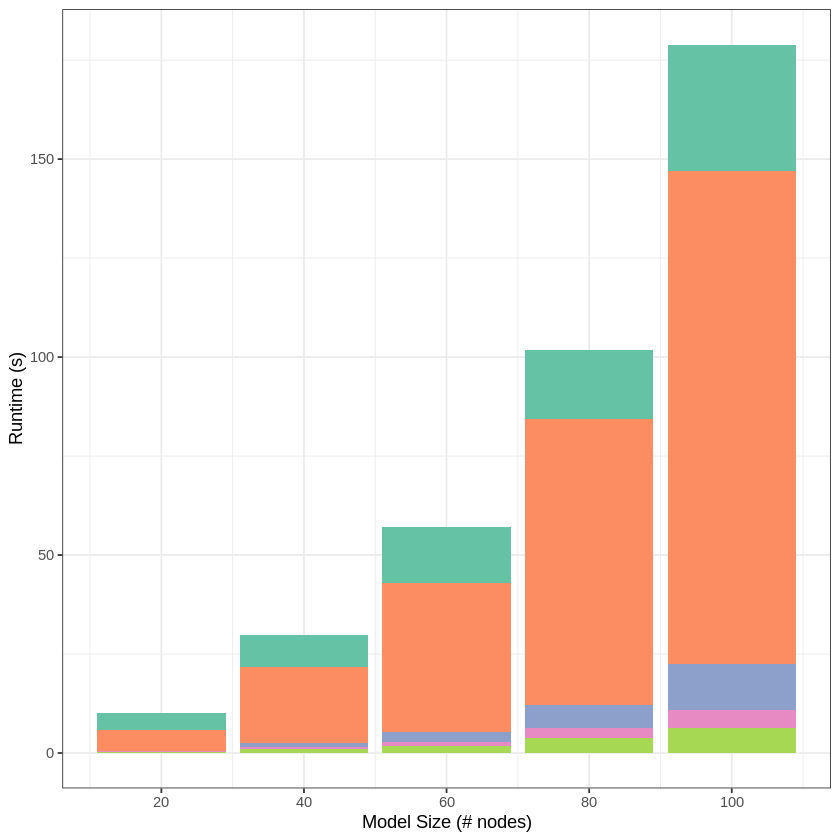

In [48]:
FamilyTreeRQ2Raw <- rbind(
    Load10Log("measurements/stats/FamilyTree//size020to-1r10n10rt3600stats.csv", 20),
    Load10Log("measurements/stats/FamilyTree/size040to-1r10n10rt3600stats.csv", 40),
    Load10Log("measurements/stats/FamilyTree//size060to-1r10n10rt3600stats.csv", 60),
    Load10Log("measurements/stats/FamilyTree//size080to-1r10n10rt3600stats.csv", 80),
    Load10Log("measurements/stats/FamilyTree//size100to-1r10n10rt3600stats.csv", 100)
)
FamilyTreeRQ2 <- FamilyTreeRQ2Raw %>% ProcessRQ2
FamilyTreeRQ2
median(FamilyTreeRQ2Raw$preprocessingTime) / 1000.0
FamilyTreeRQ2 %>% RQ2Plot('FamilyTree')

### Sat domain

Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(Solution1DetailedStatistics)`”
Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(Solution1DetailedStatistics)`”
Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(Solution1DetailedStatistics)`”
Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(Solution1DetailedStatistics)`”
Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(Solution1DetailedStatistics)`”


n,preprocessingTime,StateCoderTime,ForwardTime,BacktrackingTime,NumericalSolverSumTime,additionalTime
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20,3.3930,0.0360,0.6015,0.1010,0.5525,0.8300
40,3.5435,0.3145,1.2860,0.2645,1.0255,2.4225
60,3.3420,1.0390,2.3665,0.6415,1.5570,3.4750
80,3.2475,3.7925,4.5785,1.8590,2.0665,4.8600
100,3.3660,11.2280,8.8810,5.1165,2.7360,15.2750


[1] 3.3735

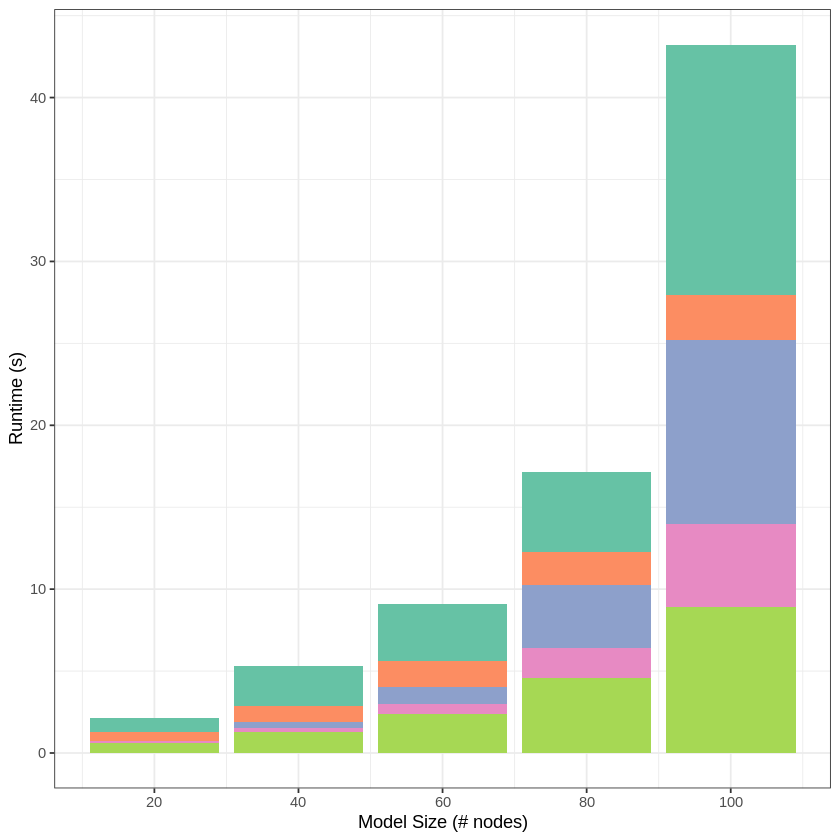

In [49]:
SatelliteRQ2Raw <- rbind(
    Load10Log("measurements/stats/Satellite//size020to-1r10n10rt3600stats.csv", 20),
    Load10Log("measurements/stats/Satellite//size040to-1r10n10rt3600stats.csv", 40),
    Load10Log("measurements/stats/Satellite//size060to-1r10n10rt3600stats.csv", 60),
    Load10Log("measurements/stats/Satellite//size080to-1r10n10rt3600stats.csv", 80),
    Load10Log("measurements/stats/Satellite//size100to-1r10n10rt3600stats.csv", 100)
)
SatelliteRQ2 <- SatelliteRQ2Raw%>% ProcessRQ2
SatelliteRQ2
median(SatelliteRQ2Raw$preprocessingTime) / 1000.0
SatelliteRQ2 %>% RQ2Plot('Satellite')

### Tax domain

Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(Solution1DetailedStatistics)`”
Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(Solution1DetailedStatistics)`”
Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(Solution1DetailedStatistics)`”
Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(Solution1DetailedStatistics)`”
Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(Solution1DetailedStatistics)`”


n,preprocessingTime,StateCoderTime,ForwardTime,BacktrackingTime,NumericalSolverSumTime,additionalTime
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20,156.6110,0.0390,1.9825,2.3225,1.5325,1.9990
40,145.8325,0.1520,3.0100,2.7595,2.7345,2.4120
60,156.0370,0.3870,4.4595,3.4015,4.1200,3.2555
80,148.0285,0.6785,6.2100,3.8615,5.6045,4.9620
100,142.0205,0.8895,6.4795,3.8965,6.3855,5.2630


[1] 150.1755

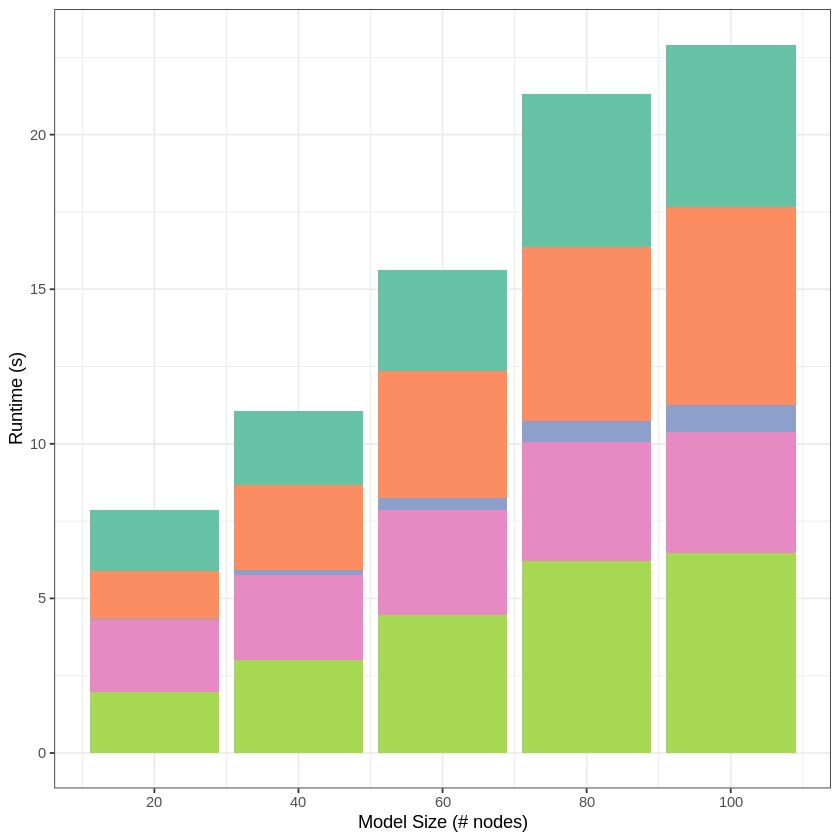

In [50]:
TaxationRQ2Raw <- rbind(
    Load10Log("measurements/stats/Taxation//size020to-1r10n10rt3600hh1stats.csv", 20),
    Load10Log("measurements/stats/Taxation//size040to-1r10n10rt3600hh2stats.csv", 40),
    Load10Log("measurements/stats/Taxation//size060to-1r10n10rt3600hh3stats.csv", 60),
    Load10Log("measurements/stats/Taxation//size080to-1r10n10rt3600hh4stats.csv", 80),
    Load10Log("measurements/stats/Taxation//size100to-1r10n10rt3600hh5stats.csv", 100)
)
TaxationRQ2 <- TaxationRQ2Raw %>% ProcessRQ2
TaxationRQ2
median(TaxationRQ2Raw$preprocessingTime) / 1000.0
TaxationRQ2 %>% RQ2Plot('Taxation')

## RQ3

Similarly to RQ2, we will create a plot for each of the 3 domains. Thus we factor the common logic out into a function.

In [51]:
RQ3Plot <- function(df, name, breaks) {
    plot <- df %>% ggplot(aes(x=n, y=time)) +
    geom_bar(stat='identity') +
    scale_x_continuous(breaks=breaks, name="Model Size (# nodes)") +
    scale_y_continuous(name="Runtime(s)") +
    theme_bw()
    ggsave(plot=plot, filename=paste0('plots/plot_RQ3_', name, '.pdf'), width=3.5, height=1.2)
    plot
}

Just like previously, we display aggreate results as a table after parsing the raw logs, then create the respective plots.

### Fam domain

n,time
<dbl>,<dbl>
100,173.7245
150,432.7295
200,904.6210
250,1641.0980
300,2571.7965


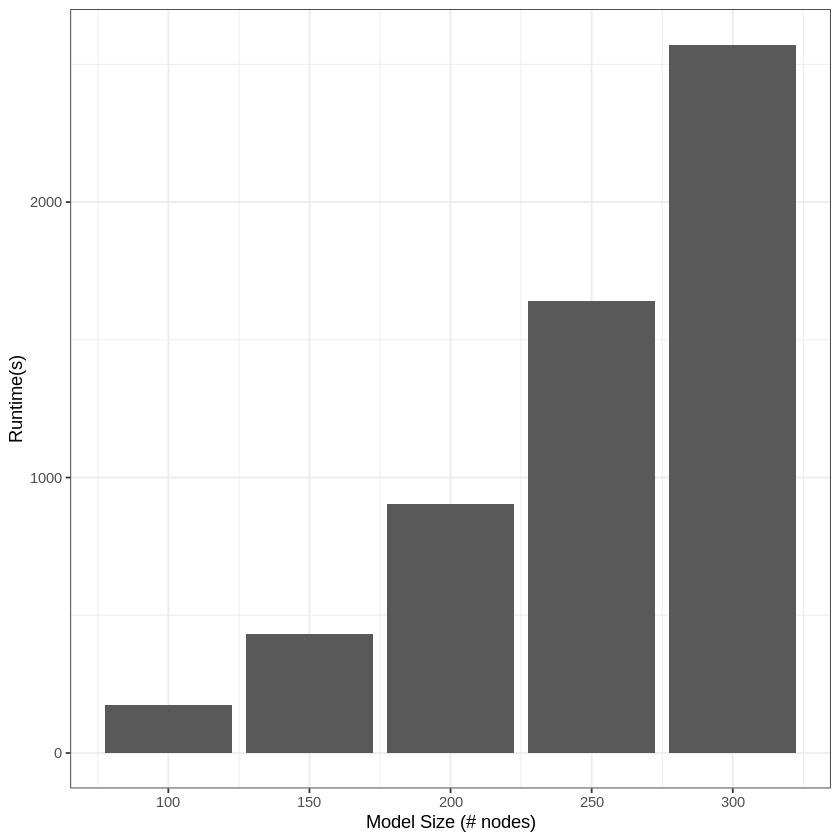

In [52]:
FamilyTreeRQ3Raw <- rbind(
    Load1Log("measurements/stats/FamilyTree/size100to-1r10n1rt3600stats.csv", 100),
    Load1Log("measurements/stats/FamilyTree/size150to-1r10n1rt3600stats.csv", 150),
    Load1Log("measurements/stats/FamilyTree/size200to-1r10n1rt3600stats.csv", 200),
    Load1Log("measurements/stats/FamilyTree/size250to-1r10n1rt3600stats.csv", 250),
    Load1Log("measurements/stats/FamilyTree/size300to-1r10n1rt3600stats.csv", 300)
)
FamilyTreeRQ3 <- FamilyTreeRQ3Raw %>% ProcessRQ3
FamilyTreeRQ3
FamilyTreeRQ3 %>% RQ3Plot('FamilyTree', c(100, 150, 200, 250, 300))

### Sat domain

n,time
<dbl>,<dbl>
100,31.3970
150,132.9415
200,373.5750
250,927.9225
300,2234.0605


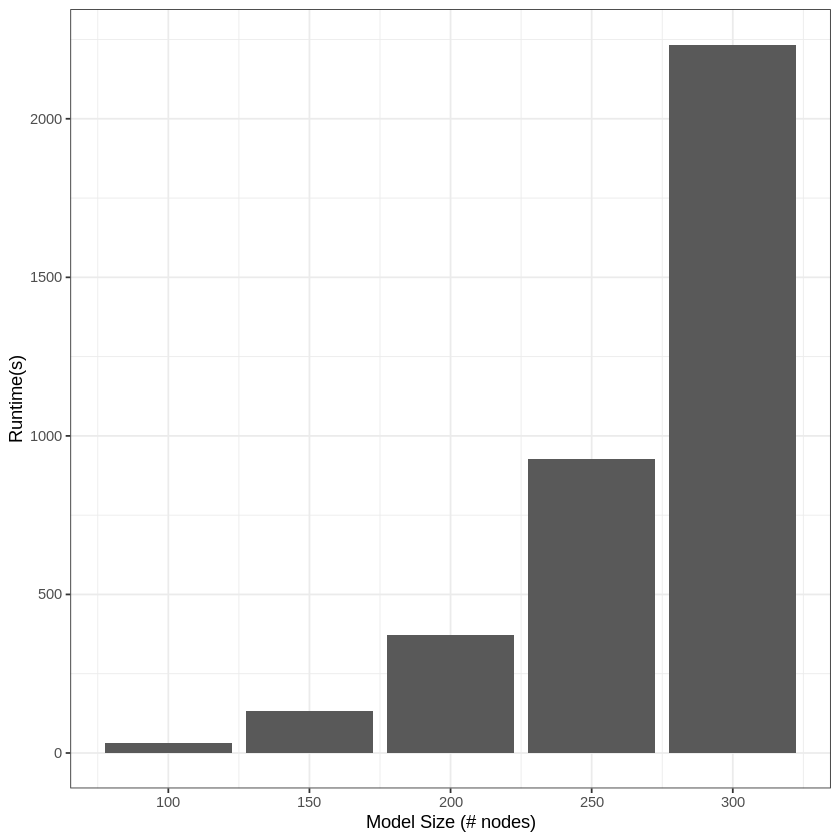

In [53]:
SatelliteRQ3Raw <- rbind(
    Load1Log("measurements/stats/Satellite//size100to-1r10n1rt3600stats.csv", 100),
    Load1Log("measurements/stats/Satellite//size150to-1r10n1rt3600stats.csv", 150),
    Load1Log("measurements/stats/Satellite//size200to-1r10n1rt3600stats.csv", 200),
    Load1Log("measurements/stats/Satellite/size250to-1r10n1rt3600stats.csv", 250),
    Load1Log("measurements/stats/Satellite/size300to-1r10n1rt3600stats.csv", 300)
)
SatelliteRQ3 <- SatelliteRQ3Raw %>% ProcessRQ3
SatelliteRQ3
SatelliteRQ3 %>% RQ3Plot('Satellite', c(100, 150, 200, 250, 300))

### Tax domain

n,time
<dbl>,<dbl>
300,275.5005
500,517.4950
700,926.3555
900,1667.9120
1100,2811.5475


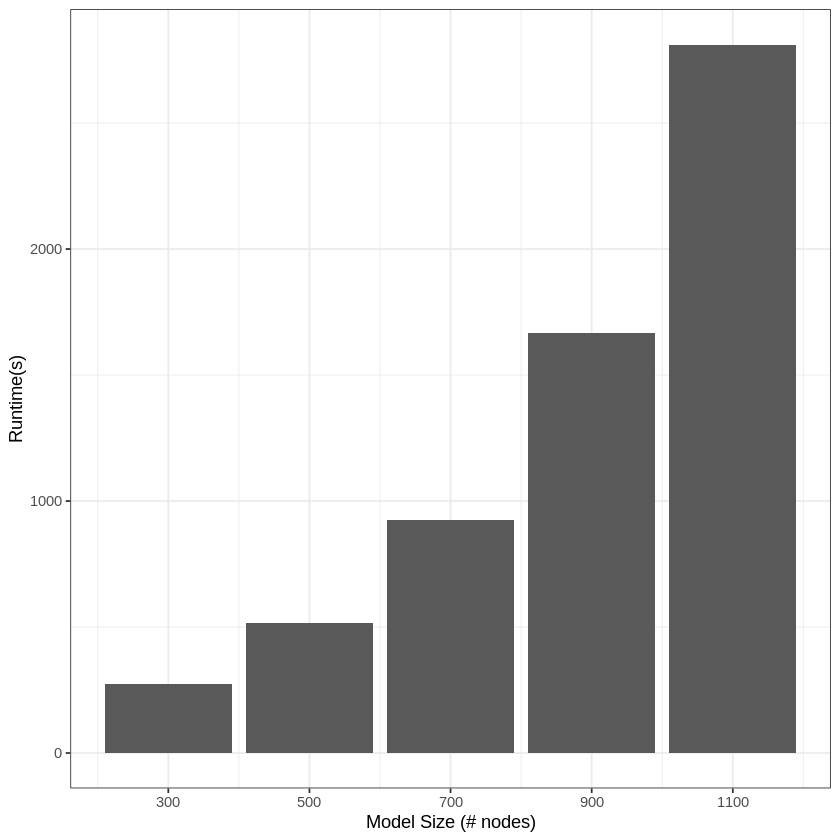

In [54]:
TaxationRQ3Raw <- rbind(
    Load1Log("measurements/stats/Taxation//size300to-1r10n1rt3600hh15stats.csv", 300),
    Load1Log("measurements/stats/Taxation//size500to-1r10n1rt3600hh25stats.csv", 500),
    Load1Log("measurements/stats/Taxation//size700to-1r10n1rt3600hh35stats.csv", 700),
    Load1Log("measurements/stats/Taxation//size900to-1r10n1rt3600hh45stats.csv", 900),
    Load1Log("measurements/stats/Taxation//size1100to-1r10n1rt3600hh55stats.csv", 1100)
)
TaxationRQ3 <- TaxationRQ3Raw %>% ProcessRQ3
TaxationRQ3
TaxationRQ3 %>% RQ3Plot('Taxation', c(300, 500, 700, 900, 1100))

## RQ4

The diversity results output by the `models20.diversity-calculator` tool are nearly ready for visualization, we only need to take care of assigning the appropriate labels for the domains (as they are used in the paper, opposed to how they are named in the filesystem) and ordering the in a logical way. Then we can generate a box plot.

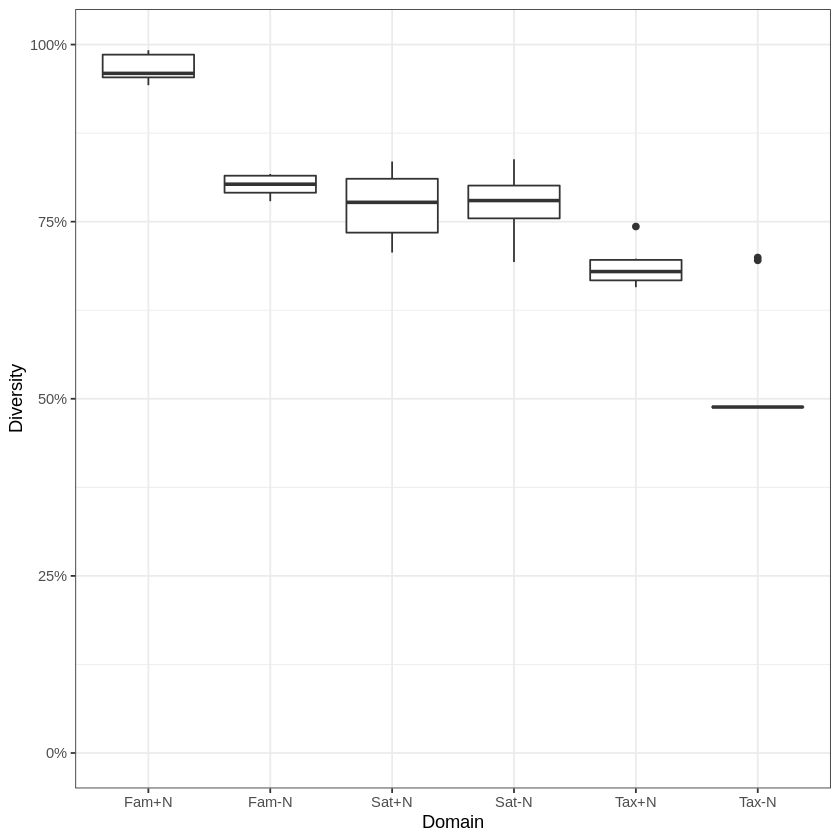

In [55]:
diversity <- read_csv('measurements/diversity.csv',
                      col_names = c('domain', 'file', 'diversity'),
                      col_types = cols(domain = col_factor(),
                                       file = col_character(),
                                       diversity = col_double()))
levels(diversity$domain) <- c("Fam+N", "Sat+N", "Tax+N", "Fam-N", "Sat-N", "Tax-N")
diversity$domain <- factor(diversity$domain, levels=c("Fam+N", "Fam-N", "Sat+N", "Sat-N", "Tax+N", "Tax-N"))
diversityPlot <- ggplot(diversity, aes(y = diversity, group=domain, x=domain)) +
    geom_boxplot() +
    scale_y_continuous(limits=c(0, 1), name="Diversity", labels = scales::percent) +
    scale_x_discrete(name="Domain") +
    theme_bw()
ggsave(plot=diversityPlot, filename='plots/plot_diversity.pdf', width=5, height=1.5*5/4)
diversityPlot